# MediaSearch Interleaved A/B Test Analysis

The Structured Data team ran an interleaved A/B test of search on Commons, and we're wanting to understand if there was a difference in preference between the two options. This analysis builds on [Estimating Preference for Ranking Functions with Clicks on Interleaved Search Results](https://people.wikimedia.org/~bearloga/notes/interleaved.html) that Mikhail wrote.

The phabricator task for this analysis is [T261759](https://phabricator.wikimedia.org/T261759)

The test started on 2020-09-10, and ended on 2020-09-17. The timestamps are roughly accurate to within a minute and are gathered from the [Server Admin Log](https://wikitech.wikimedia.org/wiki/Server_Admin_Log).

In [1]:
# https://stackoverflow.com/a/35018739/1091835
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [2]:
library(tidyr)
library(lubridate)
library(Rcpp)
import::from(
    # We don't import certain verbs (e.g. distinct, left_join, bind_rows)
    # to avoid potential name-conflicts and because they're one-time use.
    dplyr,
    # Subsetting Verbs
    keep_where = filter, select,
    # Grouping Verbs
    group_by, ungroup,
    # Manipulation Verbs
    mutate, arrange, summarize, tally,
    # Utility Functions
    case_when, if_else
)

# install.packages("remotes", repos = c(CRAN = "https://cran.rstudio.com/"))

# remotes::install_github("wikimedia/wmfdata-r")
library(wmfdata)

# remotes::install_github("wikimedia/wmfastr")
library(wmfastr)

## Options
options(mc.cores = 4, digits = 3, scipen = 500)

## Defining a custom theme for all plots
commons_theme = function() {
    theme_ipsum_rc(
        base_size = 14, axis_title_size = 12, subtitle_size = 16,
        axis_title_just = 'cm'
    )
}


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [3]:
cppFunction('CharacterVector fill_in(CharacterVector ids) {
  CharacterVector new_ids(ids.size());
  String current_id = ids[0];
  new_ids[0] = current_id;
  for (int i = 1; i < ids.size(); i++) {
    if (ids[i] != NA_STRING) {
      current_id = ids[i];
    }
    new_ids[i] = current_id;
  }
  return new_ids;
}')

In [4]:
# Process interleaved team draft
process_session <- function(df) {
  processed_session <- unsplit(lapply(split(df, df$serp_id), function(df) {
    if (is.na(df$event_extraparams[1]) || df$event_extraparams[1] == "" || df$event_extraparams[1] == "NULL") {
      visited_pages <- rep(as.character(NA), times = nrow(df))
    } else {
      from_json <- jsonlite::fromJSON(df$event_extraparams[1], simplifyVector = FALSE)
      if (!("teamDraft" %in% names(from_json)) || all(is.na(df$article_id))) {
        visited_pages <- rep(as.character(NA), times = nrow(df))
      } else {
        team_a <- unlist(from_json$teamDraft$a)
        team_b <- unlist(from_json$teamDraft$b)
        visited_pages <- vapply(df$article_id, function(article_id) {
          if (article_id %in% team_a) {
            return("A")
          } else if (article_id %in% team_b) {
            return("B")
          } else {
            return(as.character(NA))
          }
        }, "")
      }
    }
    return(visited_pages)
  }), df$serp_id)
  return(processed_session)
}

## Configuration Variables

In [5]:
## Name of the test configuration
subtest_name = 'mediasearch_commons_int'

## Start and end timestamps (approximate is fine,
## as we also filter on subtest)
start_ts = ymd_hms('2020-09-10T11:00:00Z')
end_ts = ymd_hms('2020-09-17T12:00:00Z')

In [6]:
format_ISO8601(start_ts)

[1] "2020-09-10T11:00:00"

# Data Gathering

This data gathering is based on the query used by autoreporter in [fetch_data.R](https://gerrit.wikimedia.org/r/plugins/gitiles/wikimedia/discovery/autoreporter/+/refs/heads/master/modules/data/fetch_data.R)

In [7]:
data_query = paste0("
SELECT
    coalesce(client_dt, meta.dt) AS event_ts,
    event.uniqueId AS event_id,
    event.mwSessionId,
    event.pageViewId AS page_id,
    event.articleId AS article_id,
    event.searchSessionId AS session_id,
    event.subTest AS group,
    wiki,
    MD5(LOWER(TRIM(event.query))) AS query_hash,
    event.action AS event,
    IF(event.position < 0, NULL, event.position) AS event_position,
    CASE
        WHEN event.action = 'searchResultPage' AND event.hitsReturned > 0 THEN 'TRUE'
        WHEN event.action = 'searchResultPage' AND event.hitsReturned IS NULL THEN 'FALSE'
        ELSE NULL
    END AS `some same-wiki results`,
    CASE
        WHEN event.action = 'searchResultPage' AND event.hitsReturned > -1 THEN event.hitsReturned
        WHEN event.action = 'searchResultPage' AND event.hitsReturned IS NULL THEN 0
        ELSE NULL
    END AS n_results,
    event.scroll AS event_scroll,
    event.checkin AS event_checkin,
    event.extraParams AS event_extraparams,
    event.msToDisplayResults AS load_time,
    useragent AS user_agent
  FROM event.searchsatisfaction
  WHERE year = 2020
  AND month = 9
  AND day BETWEEN 10 AND 17
  AND event.subtest = '", subtest_name, "'
  AND coalesce(client_dt, meta.dt) IS NOT NULL
  AND coalesce(client_dt, meta.dt) > '", format_ISO8601(start_ts), "'
  AND coalesce(client_dt, meta.dt) < '", format_ISO8601(end_ts), "'
  AND wiki = 'commonswiki'
  AND event.action IN ('searchResultPage', 'click', 'visitPage', 'checkin')
  AND useragent.is_bot = false
  AND CASE
    WHEN event.action = 'searchResultPage' THEN event.msToDisplayResults IS NOT NULL
    WHEN event.action = 'click' THEN event.position IS NOT NULL AND event.position > -1
    WHEN event.action = 'visitPage' THEN event.pageViewId IS NOT NULL
    WHEN event.action = 'checkin' THEN event.checkin IS NOT NULL AND event.pageViewId IS NOT NULL
    ELSE TRUE
  END;"
)

In [8]:
events = query_hive(data_query)

Don't forget to authenticate with Kerberos using kinit



In [9]:
events_backup <- events

In [17]:
# events <- events_backup

In [18]:
length(events$session_id)

[1] 929154

# Data Cleaning

In [19]:
# De-duplicating events
events <- events %>%
  mutate(
    timestamp = lubridate::ymd_hms(event_ts),
    date = as.Date(timestamp)
  ) %>%
  arrange(session_id, event_id, timestamp) %>%
  dplyr::distinct(session_id, event_id, .keep_all = TRUE)

In [20]:
length(events$session_id)

[1] 929012

In [21]:
# Delete events with negative load time
events <- events %>%
  keep_where(is.na(load_time) | load_time >= 0)

In [22]:
length(events$session_id)

[1] 929003

In [25]:
# De-duplicating SERPs
SERPs <- events %>%
  keep_where(event == "searchResultPage") %>%
  dplyr::arrange(wiki, group, session_id, timestamp) %>%
  select(c(group, session_id, page_id, query_hash)) %>%
  group_by(group, session_id, query_hash) %>%
  mutate(search_id = page_id[1]) %>%
  ungroup %>%
  select(c(group, session_id, page_id, search_id))
events <- events %>%
  dplyr::left_join(SERPs, by = c("group", "session_id", "page_id"))
rm(SERPs) # to free up memory

In [26]:
length(events$session_id)

[1] 3412361

In [27]:
# Removing events without an associated SERP (orphan clicks and check-ins)...
events <- events %>%
  keep_where(!(is.na(search_id) & !(event %in% c("visitPage", "checkin")))) %>% # remove orphan click
  group_by(session_id) %>%
  keep_where("searchResultPage" %in% event) %>% # remove orphan "visitPage" and "checkin"
  ungroup

In [28]:
length(events$session_id)

[1] 3409966

In [29]:
# Removing sessions with more than 50 searches
spider_session <- events %>%
  group_by(date, group, session_id) %>%
  summarize(n_search = length(unique(search_id))) %>%
  keep_where(n_search > 50) %>%
  {.$session_id}
events <- events %>%
  keep_where(!(session_id %in% spider_session))

`summarise()` regrouping output by 'date', 'group' (override with `.groups` argument)



In [30]:
length(events$session_id)

[1] 3364093

In [31]:
## Fill in serp_id for visitPage and checkin events
events %<>%
  mutate(serp_id = ifelse(event %in% c("visitPage", "checkin"), NA, page_id),
         event = factor(event, levels = c("searchResultPage", "click", "ssclick", "iwclick", "hover-on", "esclick", "hover-off", "visitPage", "checkin"))) %>%
  dplyr::arrange(wiki, group, session_id, timestamp, event) %>%
  mutate(serp_id = fill_in(serp_id))

In [32]:
length(events$session_id)

[1] 3364093

## Extract and Assign Teams

This assigns teams based on "teamDraft" in `event_extraparams` for SERPs, assigning them to events that have an `article_id` set.

In [33]:
events_interleaved <- events

In [34]:
events_interleaved %<>%
    keep_where(events_interleaved$event %in% c("searchResultPage", "click", "visitPage", "checkin")) %>%
    dplyr::arrange(wiki, group, session_id, timestamp, event) %>%
    mutate(search_id = fill_in(search_id))

In [35]:
length(events_interleaved$session_id)

[1] 3364093

In [36]:
events_interleaved <- data.table::data.table(events_interleaved)

In [37]:
events_interleaved[,
                   team := process_session(.SD),
                   by = c("wiki", "group", "session_id"),
                   .SDcols = c("serp_id", "event_extraparams", "article_id")]

In [38]:
events_interleaved <- events_interleaved[
    order(events_interleaved$wiki, events_interleaved$group, events_interleaved$session_id,
          events_interleaved$serp_id, events_interleaved$timestamp, events_interleaved$event), ]

In [39]:
events_interleaved[, event_extraparams := NULL, ]

In [40]:
length(events_interleaved$session_id)

[1] 3364093

# Estimation

In [41]:
click_data = events_interleaved[events_interleaved$event == 'visitPage', ]
click_data = click_data[order(click_data$session_id, click_data$timestamp), ]

In [42]:
# Remove events without an assigned team,
# or where the position is above 10, which is when interleaving stops
click_data = click_data[!is.na(team) & event_position < 10,
                        list(session_id, timestamp, event,
                             position = as.numeric(event_position), ranking_function = team)]

In [43]:
boot_click_data = interleaved_bootstraps(click_data$session_id, click_data$ranking_function)

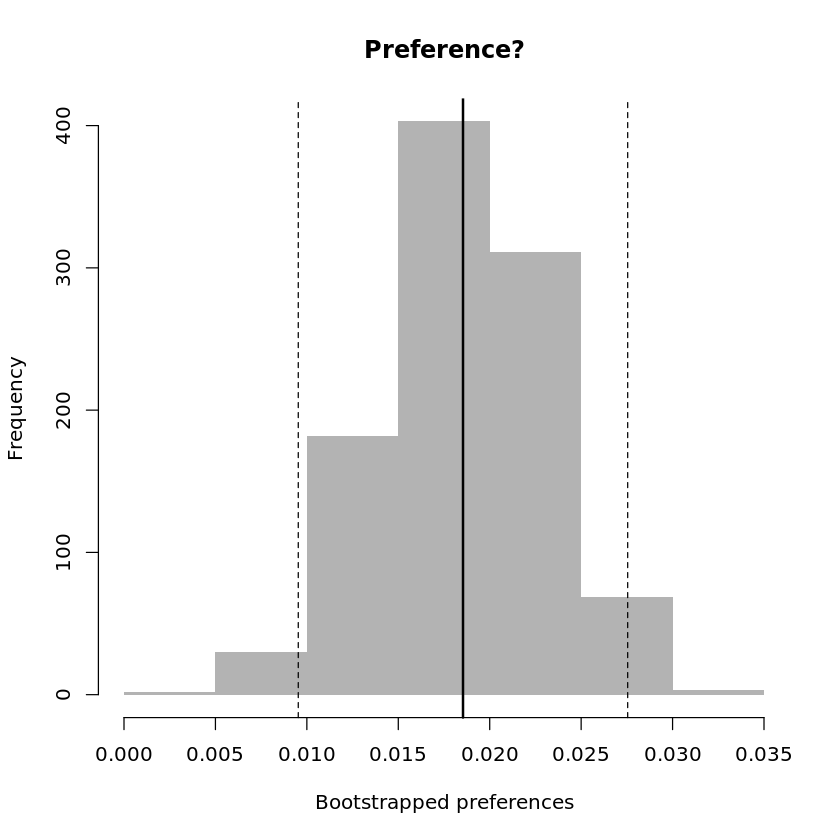

In [44]:
hist(boot_click_data, col = "gray70", border = NA,
     main = "Preference?", xlab = "Bootstrapped preferences")
abline(v = quantile(boot_click_data, c(0.025, 0.975)), lty = "dashed")
abline(v = interleaved_preference(click_data$session_id, click_data$ranking_function), lwd = 2)

We find a slight preference for team A, as seen by the preference score being positive, and the confidence interval not including zero. In this case team A is the control condition, legacy search on Commons.